### This notebook is optionally accelerated with a GPU runtime.
### If you would like to use this acceleration, please select the menu option "Runtime" -> "Change runtime type", select "Hardware Accelerator" -> "GPU" and click "SAVE"

----------------------------------------------------------------------

# Deeplabv3

*Author: Pytorch Team*

**DeepLabV3 models with ResNet-50, ResNet-101 and MobileNet-V3 backbones**

_ | _
- | -
![alt](https://pytorch.org/assets/images/deeplab1.png) | ![alt](https://pytorch.org/assets/images/deeplab2.png)

In [1]:
import torch
model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
# or any of these variants
# model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet101', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_mobilenet_v3_large', pretrained=True)
model.eval()

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:01<00:00, 159MB/s]


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

All pre-trained models expect input images normalized in the same way,
i.e. mini-batches of 3-channel RGB images of shape `(N, 3, H, W)`, where `N` is the number of images, `H` and `W` are expected to be at least `224` pixels.
The images have to be loaded in to a range of `[0, 1]` and then normalized using `mean = [0.485, 0.456, 0.406]`
and `std = [0.229, 0.224, 0.225]`.

The model returns an `OrderedDict` with two Tensors that are of the same height and width as the input Tensor, but with 21 classes.
`output['out']` contains the semantic masks, and `output['aux']` contains the auxiliary loss values per-pixel. In inference mode, `output['aux']` is not useful.
So, `output['out']` is of shape `(N, 21, H, W)`. More documentation can be found [here](https://pytorch.org/vision/stable/models.html#semantic-segmentation).

In [30]:
# Download an example image from the pytorch website
import urllib
import os

url = "https://pethelpful.com/.image/ar_1:1%2Cc_fill%2Ccs_srgb%2Cq_auto:eco%2Cw_1200/MTk2OTY2NzAwMDk5MzE1MzQw/pet-turtle-or-tortoise.png"
filename = os.path.basename(url)

print(filename)  # Output: Lizard.png
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

pet-turtle-or-tortoise.png


In [31]:
# sample execution (requires torchvision)
from PIL import Image
from torchvision import transforms
input_image = Image.open(filename)
input_image = input_image.convert("RGB")
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)['out'][0]
output_predictions = output.argmax(0)

The output here is of shape `(21, H, W)`, and at each location, there are unnormalized probabilities corresponding to the prediction of each class.
To get the maximum prediction of each class, and then use it for a downstream task, you can do `output_predictions = output.argmax(0)`.

Here's a small snippet that plots the predictions, with each color being assigned to each class (see the visualized image on the left).

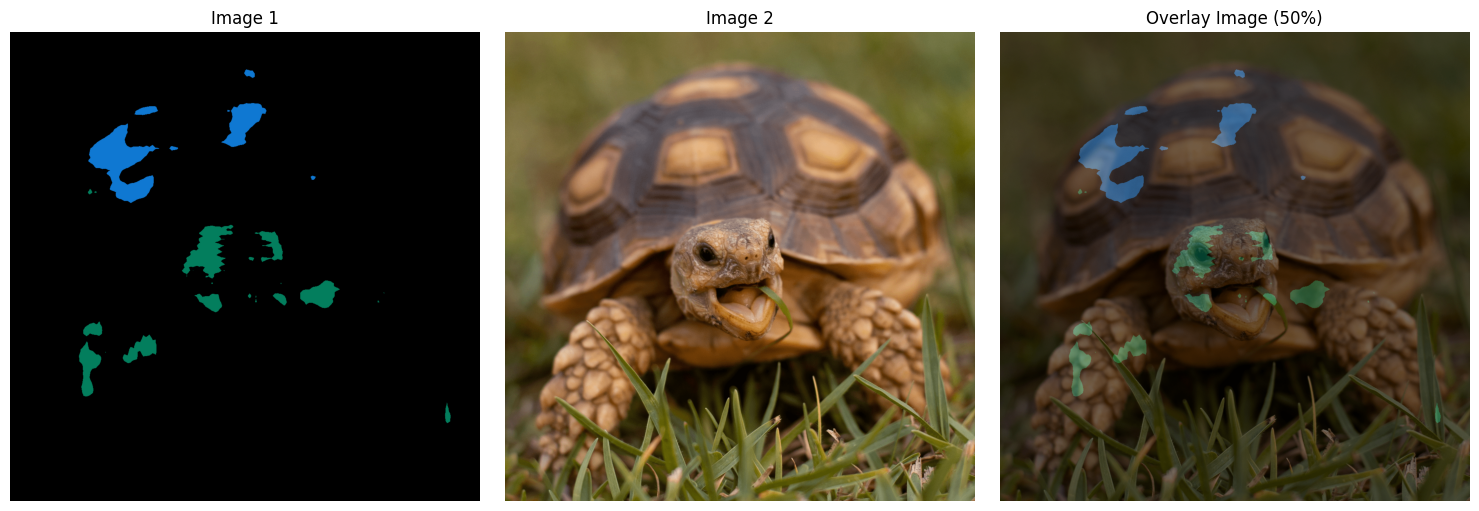

In [32]:
# create a color pallette, selecting a color for each class
palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")

# plot the semantic segmentation predictions of 21 classes in each color
r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(input_image.size)
r.putpalette(colors)

import matplotlib.pyplot as plt
from PIL import Image

# Convert images to "RGBA" mode (or "RGB" if no alpha channel is needed)
r_resized = r.resize((min(r.size[0], input_image.size[0]), min(r.size[1], input_image.size[1]))).convert("RGBA")
input_resized = input_image.resize(r_resized.size).convert("RGBA")

# Blend the two images with equal weights (50% each)
overlay_image = Image.blend(r_resized, input_resized, alpha=0.5)

# Display the images side by side along with the overlay
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

# Original image 1
plt.subplot(1, 3, 1)
plt.imshow(r)
plt.title("Image 1")
plt.axis("off")

# Original image 2
plt.subplot(1, 3, 2)
plt.imshow(input_image)
plt.title("Image 2")
plt.axis("off")

# Overlayed image
plt.subplot(1, 3, 3)
plt.imshow(overlay_image)
plt.title("Overlay Image (50%)")
plt.axis("off")

plt.tight_layout()
plt.show()

### Model Description

Deeplabv3-ResNet is constructed by a Deeplabv3 model using a ResNet-50 or ResNet-101 backbone.
Deeplabv3-MobileNetV3-Large is constructed by a Deeplabv3 model using the MobileNetV3 large backbone.
The pre-trained model has been trained on a subset of COCO train2017, on the 20 categories that are present in the Pascal VOC dataset.

Their accuracies of the pre-trained models evaluated on COCO val2017 dataset are listed below.

|    Model structure           |   Mean IOU  | Global Pixelwise Accuracy |
| ---------------------------- | ----------- | --------------------------|
| deeplabv3_resnet50           |   66.4      |   92.4                    |
| deeplabv3_resnet101          |   67.4      |   92.4                    |
| deeplabv3_mobilenet_v3_large |   60.3      |   91.2                    |

### Resources

 - [Rethinking Atrous Convolution for Semantic Image Segmentation](https://arxiv.org/abs/1706.05587)